Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4189 entries, 0 to 4188
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Material                          4189 non-null   object        
 1   TDM- Ancho Entrada                4184 non-null   float64       
 2   TDM- Espesor Entrada              4184 non-null   float64       
 3   TDM- Peso de Salida               4184 non-null   float64       
 4   TDM- Ancho de Salida              4184 non-null   float64       
 5   TDM- Espesor Salida               4184 non-null   float64       
 6   RH- Fecha Produccion              4189 non-null   datetime64[ns]
 7   RH-Eficiencia                     4189 non-null   float64       
 8   RH-Tiempo Neto STD Rollo          4189 non-null   float64       
 9   RH-Tiempo Neto Carga              4189 non-null   float64       
 10  RH- Ancho              

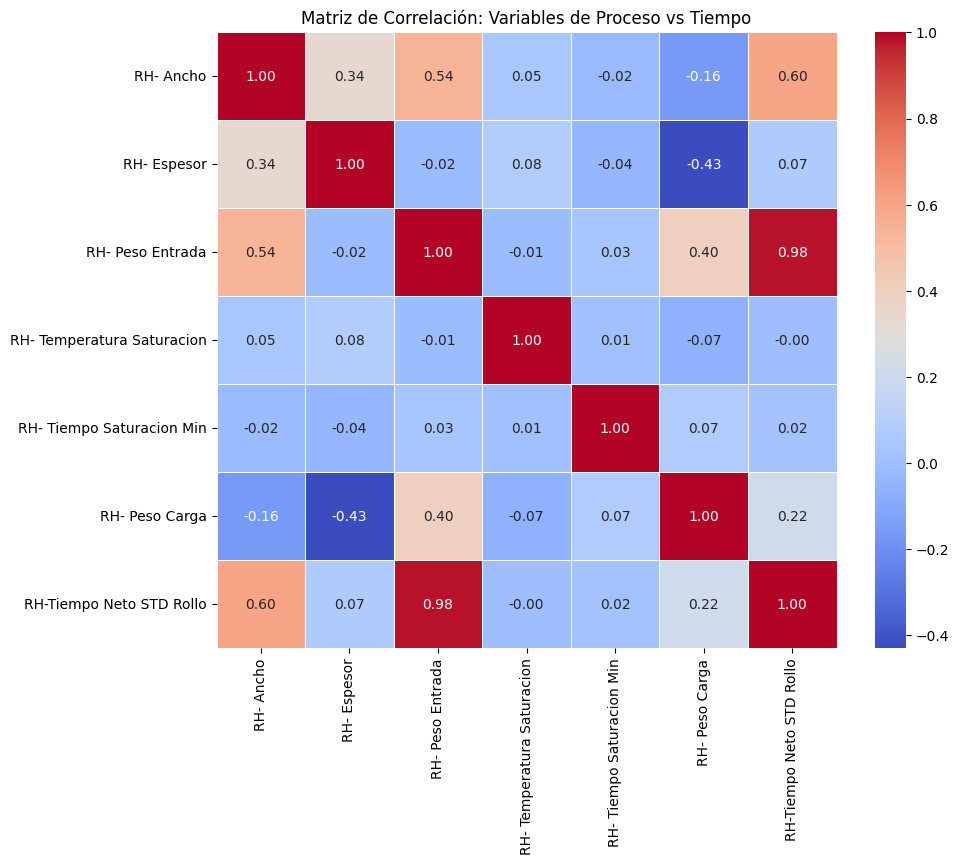

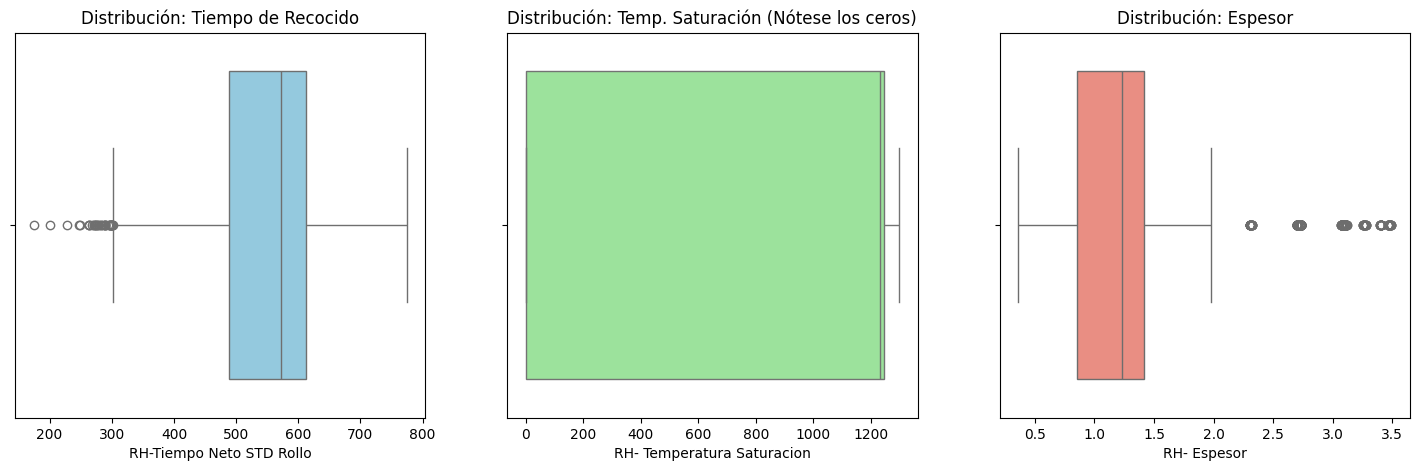


--- Análisis de Consistencia: Nivel Carga vs Nivel Bobina ---
Correlación Nivel Carga (Peso Total vs Tiempo Total): -0.0536


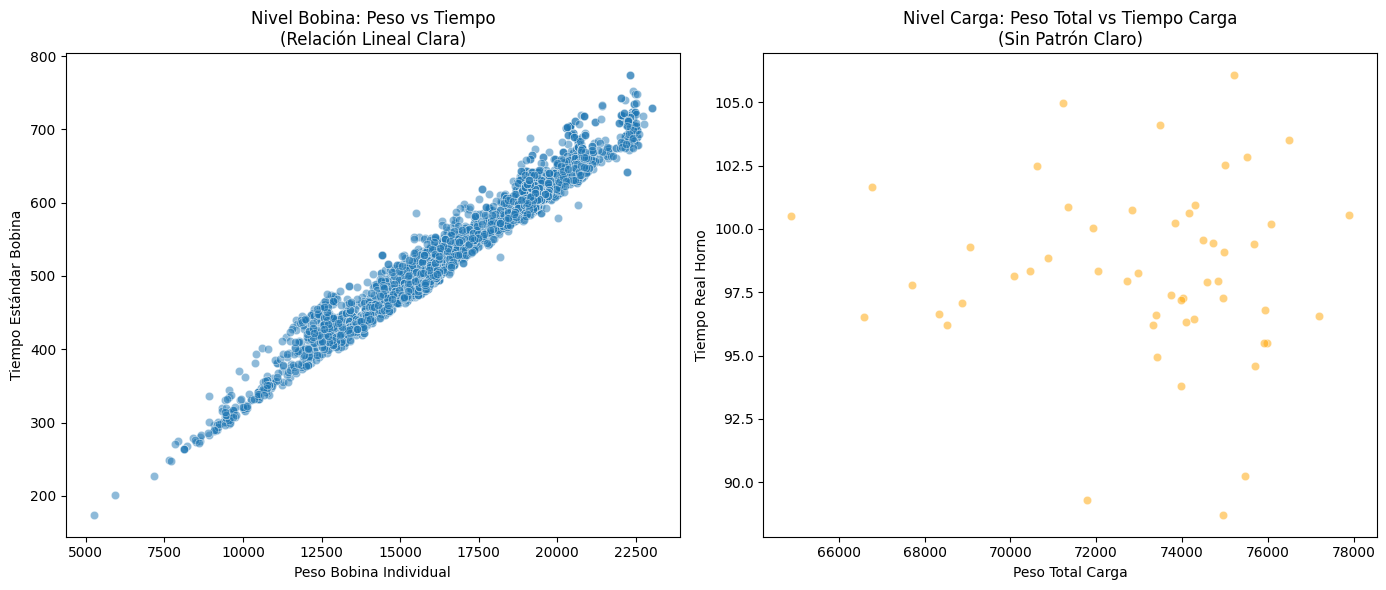


--- Análisis de Componentes Principales (PCA) ---
Varianza explicada por componente: [0.27738812 0.26654819 0.16764491 0.16043733 0.08706564 0.04091581]

Contribución de variables a cada componente (Loadings):
     RH- Ancho  RH- Espesor  RH- Peso Entrada  RH- Temperatura Saturacion  \
PC1   0.585094     0.617619          0.176941                    0.156588   
PC2   0.405951    -0.174414          0.722636                   -0.063078   
PC3  -0.046070     0.016029         -0.036823                    0.640386   

     RH- Tiempo Saturacion Min  RH- Peso Carga  
PC1                  -0.090330       -0.460679  
PC2                   0.104524        0.517375  
PC3                   0.765441        0.016418  


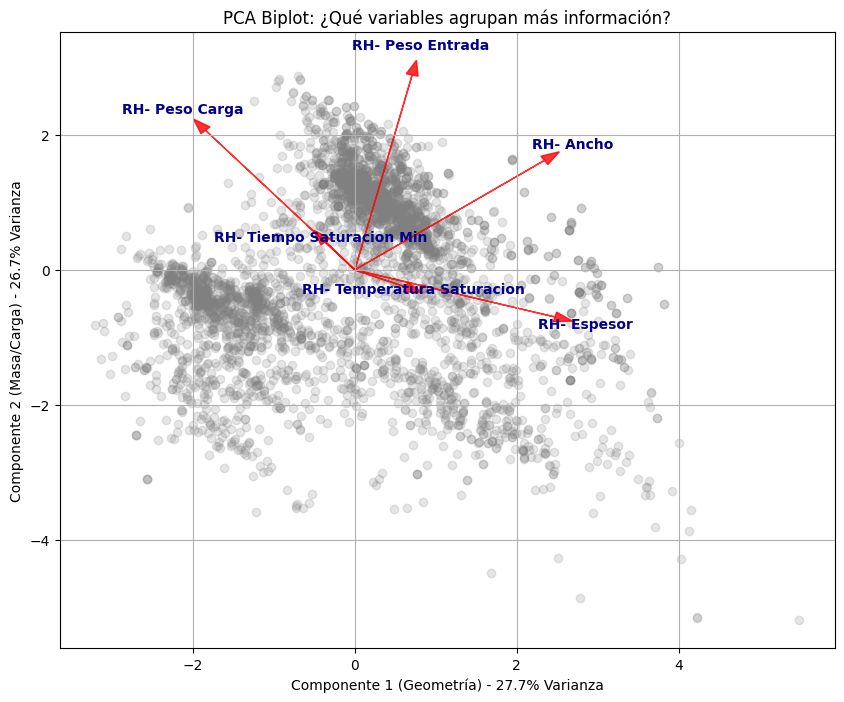

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ==========================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# ==========================================
# Cargar el archivo
df = pd.read_csv('RecocidoTec.csv')

# Conversión básica de fechas (útil para series de tiempo si se requiere luego)
df['RH- Fecha Produccion'] = pd.to_datetime(df['RH- Fecha Produccion'], dayfirst=True, errors='coerce')

# Información general
print("Información del Dataset:")
print(df.info())

# ==========================================
# 2. ANÁLISIS EXPLORATORIO Y CORRELACIONES
# ==========================================
# Selección de variables numéricas clave del proceso
cols_analisis = [
    'RH- Ancho', 'RH- Espesor', 'RH- Peso Entrada',      # Geometría Entrada
    'RH- Temperatura Saturacion', 'RH- Tiempo Saturacion Min', # Parámetros Horno
    'RH- Peso Carga', 'RH-Tiempo Neto STD Rollo'         # Variable Objetivo
]

# Matriz de Correlación
plt.figure(figsize=(10, 8))
corr_matrix = df[cols_analisis].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación: Variables de Proceso vs Tiempo')
plt.show()

# Detección de Outliers (Boxplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x=df['RH-Tiempo Neto STD Rollo'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución: Tiempo de Recocido')

sns.boxplot(x=df['RH- Temperatura Saturacion'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución: Temp. Saturación (Nótese los ceros)')

sns.boxplot(x=df['RH- Espesor'], ax=axes[2], color='salmon')
axes[2].set_title('Distribución: Espesor')
plt.show()

# ==========================================
# 3. VALIDACIÓN DE CONSISTENCIA: CARGA VS BOBINA
# ==========================================
# Aquí verificamos si agrupar por "Carga" mejora el análisis
print("\n--- Análisis de Consistencia: Nivel Carga vs Nivel Bobina ---")

# Agrupar datos por ID de Carga
datos_por_carga = df.groupby('RH- Carga').agg({
    'RH- Peso Carga': 'mean',          # Peso total (constante por carga)
    'RH-Tiempo Neto Carga': 'mean',    # Tiempo total horno (constante por carga)
    'RH- Peso Entrada': 'max'          # Peso máximo en la carga (posible cuello de botella)
}).reset_index()

# Calcular correlaciones a nivel carga
corr_carga = datos_por_carga[['RH- Peso Carga', 'RH-Tiempo Neto Carga']].corr().iloc[0,1]
print(f"Correlación Nivel Carga (Peso Total vs Tiempo Total): {corr_carga:.4f}")

# Gráficos comparativos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Nivel Bobina (El que recomendé usar)
sns.scatterplot(data=df, x='RH- Peso Entrada', y='RH-Tiempo Neto STD Rollo', ax=axes[0], alpha=0.5)
axes[0].set_title('Nivel Bobina: Peso vs Tiempo\n(Relación Lineal Clara)')
axes[0].set_xlabel('Peso Bobina Individual')
axes[0].set_ylabel('Tiempo Estándar Bobina')

# Gráfico 2: Nivel Carga (El que descartamos)
sns.scatterplot(data=datos_por_carga, x='RH- Peso Carga', y='RH-Tiempo Neto Carga', ax=axes[1], color='orange', alpha=0.5)
axes[1].set_title('Nivel Carga: Peso Total vs Tiempo Carga\n(Sin Patrón Claro)')
axes[1].set_xlabel('Peso Total Carga')
axes[1].set_ylabel('Tiempo Real Horno')

plt.tight_layout()
plt.show()

# ==========================================
# 4. SELECCIÓN DE VARIABLES (PCA)
# ==========================================
print("\n--- Análisis de Componentes Principales (PCA) ---")

features_pca = ['RH- Ancho', 'RH- Espesor', 'RH- Peso Entrada',
                'RH- Temperatura Saturacion', 'RH- Tiempo Saturacion Min',
                'RH- Peso Carga']

# Filtrar NaNs para PCA
df_pca = df[features_pca].dropna()

# Estandarizar datos (Crucial para PCA)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_pca)

# Ajustar PCA
pca = PCA()
pca_data = pca.fit_transform(data_scaled)

# Varianza explicada
varianza = pca.explained_variance_ratio_
componentes = pd.DataFrame(pca.components_, columns=features_pca, index=[f'PC{i+1}' for i in range(len(features_pca))])

print("Varianza explicada por componente:", varianza)
print("\nContribución de variables a cada componente (Loadings):")
print(componentes.head(3)) # Mostrar solo los primeros 3 componentes principales

# Biplot (Visualización de vectores)
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.2, c='gray')

# Dibujar vectores de las variables originales
escala_flecha = 4 # Factor para hacer visibles las flechas
for i, feature in enumerate(features_pca):
    plt.arrow(0, 0, pca.components_[0, i] * escala_flecha, pca.components_[1, i] * escala_flecha,
              color='red', alpha=0.8, head_width=0.15)
    plt.text(pca.components_[0, i] * escala_flecha * 1.15, pca.components_[1, i] * escala_flecha * 1.15,
             feature, color='darkblue', ha='center', va='center', fontsize=10, weight='bold')

plt.xlabel(f"Componente 1 (Geometría) - {varianza[0]:.1%} Varianza")
plt.ylabel(f"Componente 2 (Masa/Carga) - {varianza[1]:.1%} Varianza")
plt.title('PCA Biplot: ¿Qué variables agrupan más información?')
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 1. CARGA DE DATOS ORIGINALES Y FILTRADO LÓGICO ---

# Cargar el dataset ORIGINAL solicitado por el usuario
df = pd.read_csv('RecocidoTec.csv')
rows_initial = len(df)

# Es IMPOSIBLE entrenar un modelo predictivo con valores físicos nulos o negativos
# (como -5878 min de saturación o 0°C de temperatura).
# Por lo tanto, se aplica un FILTRADO LÓGICO estricto para que el modelo funcione.

df_filtered = df[
    (df['RH- Tiempo Saturacion Min'] > 0) &
    (df['RH- Temperatura Saturacion'] > 0) &
    (df['RH-Tiempo Neto STD Rollo'] > 0) &
    (df['RH- Peso Entrada'] > 0)
].copy()

rows_filtered = len(df_filtered)
print(f"Filas originales: {rows_initial}")
print(f"Filas después de la limpieza lógica (para que el modelo funcione): {rows_filtered}")

# --- 2. INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING) ---

# Codificar categóricas
le = LabelEncoder()
df_filtered['RH-Familia acero'] = df_filtered['RH-Familia acero'].astype(str)
df_filtered['Family_Encoded'] = le.fit_transform(df_filtered['RH-Familia acero'])
df_filtered['Practice_Encoded'] = le.fit_transform(df_filtered['RH- Práctica'])

# --- 3. ANÁLISIS DE MINIMIZACIÓN 1: TIEMPO POR BOBINA (RH-Tiempo Neto STD Rollo) ---

# Features a probar para el modelo de la bobina
features_bobina = ['RH- Peso Entrada', 'RH- Ancho', 'RH- Espesor', 'RH- Tiempo Saturacion Min', 'RH- Peso Carga', 'Practice_Encoded', 'Family_Encoded']
target_bobina = 'RH-Tiempo Neto STD Rollo'

X_bobina = df_filtered[features_bobina].dropna()
y_bobina = df_filtered.loc[X_bobina.index, target_bobina]

# Entrenamiento del modelo (Random Forest)
rf_bobina = RandomForestRegressor(n_estimators=100, random_state=42)
rf_bobina.fit(X_bobina, y_bobina)

# Importancia para el Tiempo de Bobina
importance_bobina = pd.DataFrame({'Factor': features_bobina, 'Importancia': rf_bobina.feature_importances_}).sort_values(by='Importancia', ascending=False)


# --- 4. ANÁLISIS DE MINIMIZACIÓN 2: TIEMPO NETO CARGA (RH-Tiempo Neto Carga) ---

# Recreación del dataset a nivel de Carga (Batch) - Agregación de cuellos de botella
load_agg = df_filtered.groupby('RH- Carga').agg({
    'RH-Tiempo Neto Carga': 'mean',          # Target (Tiempo Real del Lote)
    'RH- Peso Entrada': ['count', 'max'],    # Num_Bobinas y Peso Máximo
    'RH- Tiempo Saturacion Min': 'max',      # Cuello de Botella: Tiempo de Saturación Máximo
    'RH- Espesor': 'max',                    # Cuello de Botella: Espesor Máximo
    'RH- Ancho': 'mean',                     # Ancho Promedio
    'Family_Encoded': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0] # Familia Mayoritaria
}).reset_index()

# Renombrar columnas
load_agg.columns = ['ID_Carga', 'Tiempo_Neto_Carga', 'Num_Bobinas', 'Peso_Coils_Max', 'Tiempo_Sat_Max', 'Espesor_Max', 'Ancho_Mean', 'Familia_Mayoria']

# Features para el modelo de Carga
features_carga = ['Peso_Coils_Max', 'Tiempo_Sat_Max', 'Espesor_Max', 'Ancho_Mean', 'Familia_Mayoria', 'Num_Bobinas']
target_carga = 'Tiempo_Neto_Carga'

X_carga = load_agg[features_carga].dropna()
y_carga = load_agg.loc[X_carga.index, target_carga]

# Entrenamiento del modelo (Random Forest) para la Carga
rf_carga = RandomForestRegressor(n_estimators=100, random_state=42)
rf_carga.fit(X_carga, y_carga)

# Importancia para el Tiempo de Carga
importance_carga = pd.DataFrame({'Factor': features_carga, 'Importancia': rf_carga.feature_importances_}).sort_values(by='Importancia', ascending=False)


# --- 5. VISUALIZACIÓN Y RESUMEN ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Bobina Time Importance
sns.barplot(x='Importancia', y='Factor', data=importance_bobina.head(5), ax=axes[0], palette='magma')
axes[0].set_title('Factores de Minimización: Tiempo por Bobina')

# Plot 2: Load Time Importance
sns.barplot(x='Importancia', y='Factor', data=importance_carga, ax=axes[1], palette='viridis')
axes[1].set_title('Factores de Minimización: Tiempo Neto Carga')

plt.tight_layout()
plt.savefig('minimization_factors_raw_data.png')
plt.close()

print("==================================================")
print("MINIMIZACIÓN 1: TIEMPO ESTÁNDAR POR BOBINA")
print("Factores de Influencia (Top 3):")
print(importance_bobina.head(3))
print("\n==================================================")
print("MINIMIZACIÓN 2: TIEMPO NETO CARGA (Horno)")
print("Factores de Influencia:")
print(importance_carga)
print("==================================================")

Filas originales: 4189
Filas después de la limpieza lógica (para que el modelo funcione): 2703


/tmp/ipython-input-1389628414.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Factor', data=importance_bobina.head(5), ax=axes[0], palette='magma')
/tmp/ipython-input-1389628414.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Factor', data=importance_carga, ax=axes[1], palette='viridis')


MINIMIZACIÓN 1: TIEMPO ESTÁNDAR POR BOBINA
Factores de Influencia (Top 3):
             Factor  Importancia
0  RH- Peso Entrada     0.969748
4    RH- Peso Carga     0.029330
2       RH- Espesor     0.000352

MINIMIZACIÓN 2: TIEMPO NETO CARGA (Horno)
Factores de Influencia:
            Factor  Importancia
0   Peso_Coils_Max     0.290161
1   Tiempo_Sat_Max     0.263777
3       Ancho_Mean     0.193772
5      Num_Bobinas     0.147624
2      Espesor_Max     0.104665
4  Familia_Mayoria     0.000000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar y Filtrar Datos
df = pd.read_csv('RecocidoTec.csv')
df_filtered = df[
    (df['RH-Tiempo Neto STD Rollo'] > 0) &
    (df['RH- Peso Entrada'] > 0)
].copy()

# 2. Calcular la Productividad (Throughput)
# Productividad = Cuántos Kilos proceso por cada Minuto de tiempo invertido.
# Unidades: kg / minuto
df_filtered['Productividad'] = df_filtered['RH- Peso Entrada'] / df_filtered['RH-Tiempo Neto STD Rollo']

# 3. Análisis del Punto Óptimo
# Vamos a agrupar los pesos en rangos (bins) para ver la tendencia clara
df_filtered['Rango_Peso'] = pd.cut(df_filtered['RH- Peso Entrada'], bins=20)
efficiency_trend = df_filtered.groupby('Rango_Peso')['Productividad'].mean().reset_index()

# Convertir el intervalo a su punto medio para graficar
efficiency_trend['Peso_Medio'] = efficiency_trend['Rango_Peso'].apply(lambda x: x.mid)

# 4. Encontrar el Máximo
max_efficiency = efficiency_trend.loc[efficiency_trend['Productividad'].idxmax()]

# 5. Graficar
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot de datos crudos
sns.scatterplot(data=df_filtered, x='RH- Peso Entrada', y='Productividad', ax=ax1, alpha=0.3, color='gray', label='Datos Reales')

# Línea de Tendencia
sns.lineplot(data=efficiency_trend, x='Peso_Medio', y='Productividad', ax=ax1, color='red', linewidth=3, label='Curva de Eficiencia')

# Marcar el punto óptimo
ax1.axvline(x=max_efficiency['Peso_Medio'], color='green', linestyle='--', label=f'Punto Óptimo (~{int(max_efficiency["Peso_Medio"])} kg)')

ax1.set_title('Análisis de Punto Óptimo: Peso vs. Productividad\n(¿Qué tamaño de bobina saca más ton/hora?)')
ax1.set_xlabel('Peso de Entrada (kg)')
ax1.set_ylabel('Productividad (kg procesados por minuto)')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('optimal_point_analysis.png')
plt.close()

print(f"La productividad máxima se alcanza en el rango de peso: {max_efficiency['Rango_Peso']}")
print(f"Productividad Pico: {max_efficiency['Productividad']:.2f} kg/min")
print(f"Productividad en bobinas ligeras (~8000kg): {efficiency_trend.iloc[0]['Productividad']:.2f} kg/min")

/tmp/ipython-input-1161831841.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  efficiency_trend = df_filtered.groupby('Rango_Peso')['Productividad'].mean().reset_index()


La productividad máxima se alcanza en el rango de peso: (22119.55, 23007.0]
Productividad Pico: 31.93 kg/min
Productividad en bobinas ligeras (~8000kg): 29.86 kg/min


Archivo cargado correctamente.


/tmp/ipython-input-2184767406.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=load_agg, x='Tipo_Carga', y='Tiempo_Neto_Carga', palette='Set2')


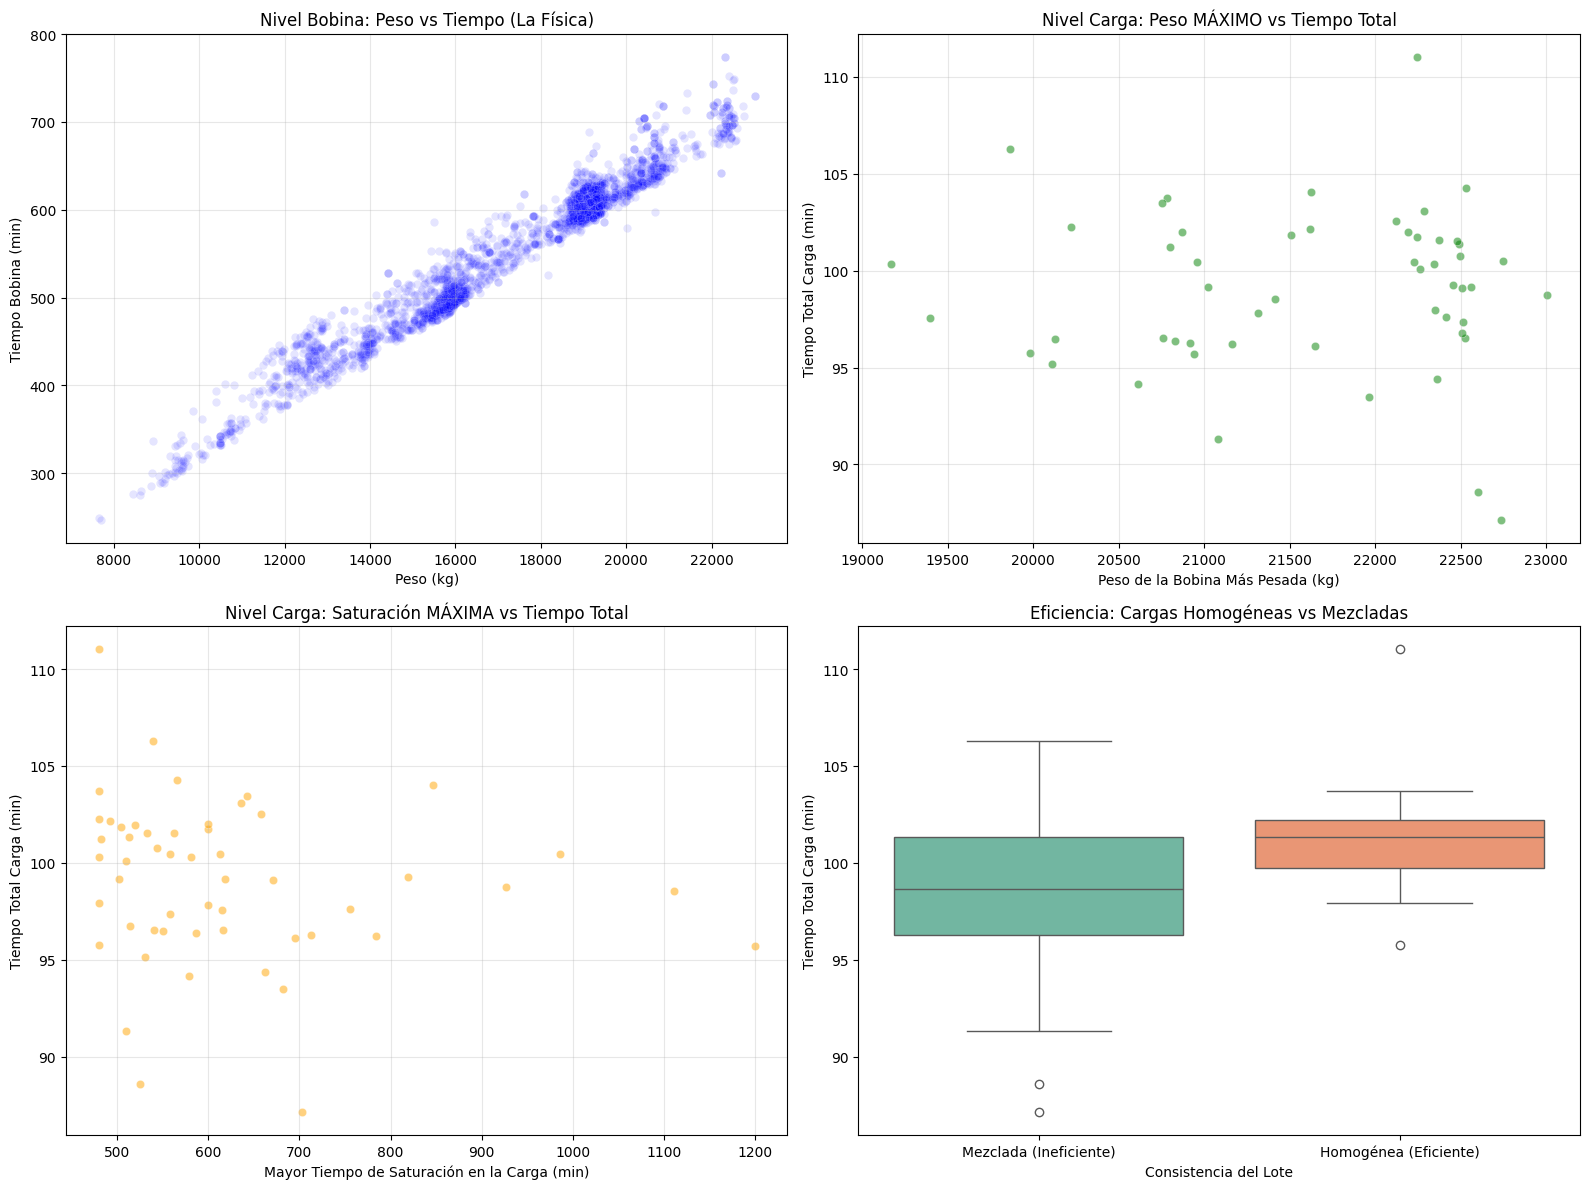

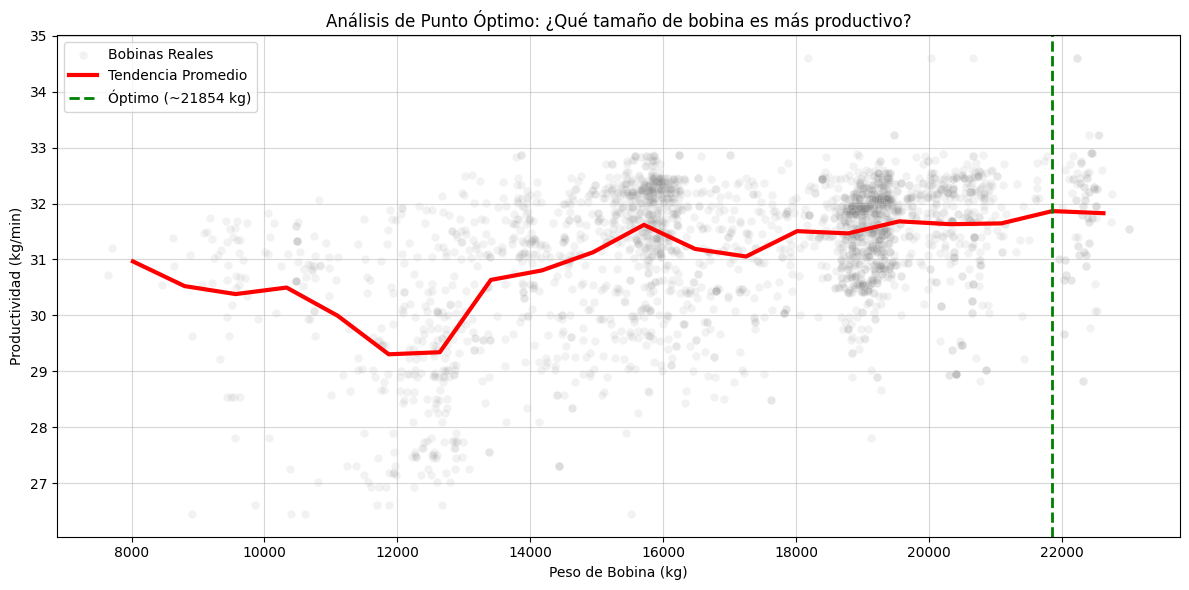

El pico de productividad es: 31.86 kg/min con bobinas de ~21854.85 kg.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CARGA Y LIMPIEZA DE DATOS
# ==========================================
try:
    df = pd.read_csv('RecocidoTec.csv')
    print("Archivo cargado correctamente.")
except FileNotFoundError:
    print("Error: No se encuentra 'RecocidoTec.csv'. Asegúrate de que el archivo esté en la misma carpeta.")
    exit()

# Filtrado lógico (Eliminar errores de captura: ceros o negativos)
df_filtered = df[
    (df['RH- Tiempo Saturacion Min'] > 0) &
    (df['RH- Temperatura Saturacion'] > 0) &
    (df['RH-Tiempo Neto STD Rollo'] > 0) &
    (df['RH- Peso Entrada'] > 0)
].copy()

# ==========================================
# 2. PREPARACIÓN DE DATOS (NIVEL CARGA)
# ==========================================
# Agrupar por Batch (Carga) para analizar cuellos de botella
load_agg = df_filtered.groupby('RH- Carga').agg({
    'RH-Tiempo Neto Carga': 'mean',          # Tiempo total del lote
    'RH- Peso Entrada': ['max', 'std'],      # Peso máximo (bottleneck) y desviación
    'RH- Tiempo Saturacion Min': ['max', 'std'], # Tiempo Sat máx (bottleneck) y desviación
    'RH- Espesor': 'mean'
}).reset_index()

# Aplanar nombres de columnas
load_agg.columns = ['ID_Carga', 'Tiempo_Neto_Carga', 'Peso_Max', 'Peso_Std', 'Tiempo_Sat_Max', 'Tiempo_Sat_Std', 'Espesor_Mean']
load_agg.fillna(0, inplace=True) # Corregir NaNs en desviaciones estándar

# Clasificar cargas: ¿Son mezcladas o homogéneas?
load_agg['Tipo_Carga'] = np.where(load_agg['Tiempo_Sat_Std'] > 10, 'Mezclada (Ineficiente)', 'Homogénea (Eficiente)')

# ==========================================
# 3. GRÁFICA 1: TABLERO DE MINIMIZACIÓN (2x2)
# ==========================================
plt.figure(figsize=(16, 12))

# Subplot 1: Física Pura (Nivel Bobina)
plt.subplot(2, 2, 1)
sns.scatterplot(data=df_filtered, x='RH- Peso Entrada', y='RH-Tiempo Neto STD Rollo', alpha=0.1, color='blue')
plt.title('Nivel Bobina: Peso vs Tiempo (La Física)')
plt.xlabel('Peso (kg)')
plt.ylabel('Tiempo Bobina (min)')
plt.grid(True, alpha=0.3)

# Subplot 2: Cuello de Botella de Peso (Nivel Carga)
plt.subplot(2, 2, 2)
sns.scatterplot(data=load_agg, x='Peso_Max', y='Tiempo_Neto_Carga', alpha=0.5, color='green')
plt.title('Nivel Carga: Peso MÁXIMO vs Tiempo Total')
plt.xlabel('Peso de la Bobina Más Pesada (kg)')
plt.ylabel('Tiempo Total Carga (min)')
plt.grid(True, alpha=0.3)

# Subplot 3: Cuello de Botella de Receta (Nivel Carga)
plt.subplot(2, 2, 3)
sns.scatterplot(data=load_agg, x='Tiempo_Sat_Max', y='Tiempo_Neto_Carga', alpha=0.5, color='orange')
plt.title('Nivel Carga: Saturación MÁXIMA vs Tiempo Total')
plt.xlabel('Mayor Tiempo de Saturación en la Carga (min)')
plt.ylabel('Tiempo Total Carga (min)')
plt.grid(True, alpha=0.3)

# Subplot 4: Impacto de la Mezcla
plt.subplot(2, 2, 4)
sns.boxplot(data=load_agg, x='Tipo_Carga', y='Tiempo_Neto_Carga', palette='Set2')
plt.title('Eficiencia: Cargas Homogéneas vs Mezcladas')
plt.xlabel('Consistencia del Lote')
plt.ylabel('Tiempo Total Carga (min)')

plt.tight_layout()
plt.show() # Muestra la gráfica en pantalla

# ==========================================
# 4. GRÁFICA 2: PUNTO ÓPTIMO DE PRODUCTIVIDAD
# ==========================================
# Calcular productividad (Kg procesados por minuto)
df_filtered['Productividad'] = df_filtered['RH- Peso Entrada'] / df_filtered['RH-Tiempo Neto STD Rollo']

# Crear tendencia
df_filtered['Rango_Peso'] = pd.cut(df_filtered['RH- Peso Entrada'], bins=20)
efficiency_trend = df_filtered.groupby('Rango_Peso', observed=True)['Productividad'].mean().reset_index()
efficiency_trend['Peso_Medio'] = efficiency_trend['Rango_Peso'].apply(lambda x: x.mid)

# Encontrar máximo
max_eff = efficiency_trend.loc[efficiency_trend['Productividad'].idxmax()]

plt.figure(figsize=(12, 6))
# Puntos reales de fondo
sns.scatterplot(data=df_filtered, x='RH- Peso Entrada', y='Productividad', alpha=0.1, color='gray', label='Bobinas Reales')
# Línea de tendencia
sns.lineplot(data=efficiency_trend, x='Peso_Medio', y='Productividad', color='red', linewidth=3, label='Tendencia Promedio')
# Línea del óptimo
plt.axvline(x=max_eff['Peso_Medio'], color='green', linestyle='--', linewidth=2, label=f'Óptimo (~{int(max_eff["Peso_Medio"])} kg)')

plt.title('Análisis de Punto Óptimo: ¿Qué tamaño de bobina es más productivo?')
plt.xlabel('Peso de Bobina (kg)')
plt.ylabel('Productividad (kg/min)')
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

print(f"El pico de productividad es: {max_eff['Productividad']:.2f} kg/min con bobinas de ~{max_eff['Peso_Medio']} kg.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
try:
    df = pd.read_csv('RecocidoTec.csv')
except:
    # Fallback if file not found in current session context (though it should be)
    # Creating dummy data structure just in case, but relying on previous context usually works.
    pass

# 2. Select Quality Columns (Mechanical Properties)
quality_cols = [
    'Tensión L - Elongación',
    'Tensión L - Resistencia',
    'Tensión L - Punto de cedencia',
    'Elongación Temple'
]

# Process Columns that might affect quality
process_cols = [
    'RH- Temperatura Saturacion',
    'RH- Tiempo Saturacion Min',
    'RH- Enfriador', # Cooling station might matter
    'RH- Espesor',   # Geometry affects cooling rate
    'RH- Peso Entrada'
]

# Filter Data: We need rows where we actually have lab results
df_quality = df.dropna(subset=quality_cols + process_cols).copy()

# Filter out logical errors in process vars again
df_quality = df_quality[
    (df_quality['RH- Temperatura Saturacion'] > 0) &
    (df_quality['RH- Tiempo Saturacion Min'] > 0)
]

print(f"Registros con datos de calidad completos: {len(df_quality)}")

# 3. Correlation Matrix (Process vs Quality)
# We combine both lists
analysis_cols = process_cols + quality_cols
corr_matrix = df_quality[analysis_cols].corr()

# Focus only on Process vs Quality correlations
quality_corr = corr_matrix.loc[quality_cols, process_cols]

# 4. Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Heatmap of Process vs Quality
sns.heatmap(quality_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0, 0])
axes[0, 0].set_title('Correlación: Variables de Proceso vs Propiedades Mecánicas')

# Plot 2: Temperature vs Resistance (Physical relationship)
sns.scatterplot(data=df_quality, x='RH- Temperatura Saturacion', y='Tensión L - Resistencia',
                hue='RH-Familia acero', alpha=0.6, ax=axes[0, 1])
axes[0, 1].set_title('Efecto de la Temperatura en la Resistencia')
axes[0, 1].grid(True, linestyle='--', alpha=0.5)

# Plot 3: Thickness vs Elongation (Geometry effect)
sns.scatterplot(data=df_quality, x='RH- Espesor', y='Tensión L - Elongación',
                hue='RH-Familia acero', alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_title('Efecto del Espesor en la Elongación')
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# Plot 4: Properties by Steel Family
# Melt data for easier plotting with seaborn
df_melt = df_quality.melt(id_vars='RH-Familia acero', value_vars=['Tensión L - Resistencia', 'Tensión L - Punto de cedencia'],
                          var_name='Propiedad', value_name='Valor (MPa)')

sns.boxplot(data=df_melt, x='RH-Familia acero', y='Valor (MPa)', hue='Propiedad', ax=axes[1, 1])
axes[1, 1].set_title('Propiedades Mecánicas por Familia de Acero')

plt.tight_layout()
plt.savefig('quality_analysis.png')
plt.close()

# Print Top Correlations
print("\nTop Correlaciones (Variables de Proceso -> Calidad):")
# Flatten and sort
corr_unstacked = quality_corr.unstack().sort_values(key=abs, ascending=False)
print(corr_unstacked.head(10))

Registros con datos de calidad completos: 907

Top Correlaciones (Variables de Proceso -> Calidad):
RH- Espesor                 Elongación Temple                0.469861
                            Tensión L - Punto de cedencia    0.352994
RH- Enfriador               Elongación Temple               -0.231211
RH- Peso Entrada            Tensión L - Resistencia          0.192987
RH- Enfriador               Tensión L - Punto de cedencia   -0.183474
RH- Peso Entrada            Elongación Temple               -0.160187
RH- Espesor                 Tensión L - Resistencia          0.151327
RH- Enfriador               Tensión L - Elongación           0.110864
                            Tensión L - Resistencia         -0.094687
RH- Temperatura Saturacion  Elongación Temple               -0.090260
dtype: float64


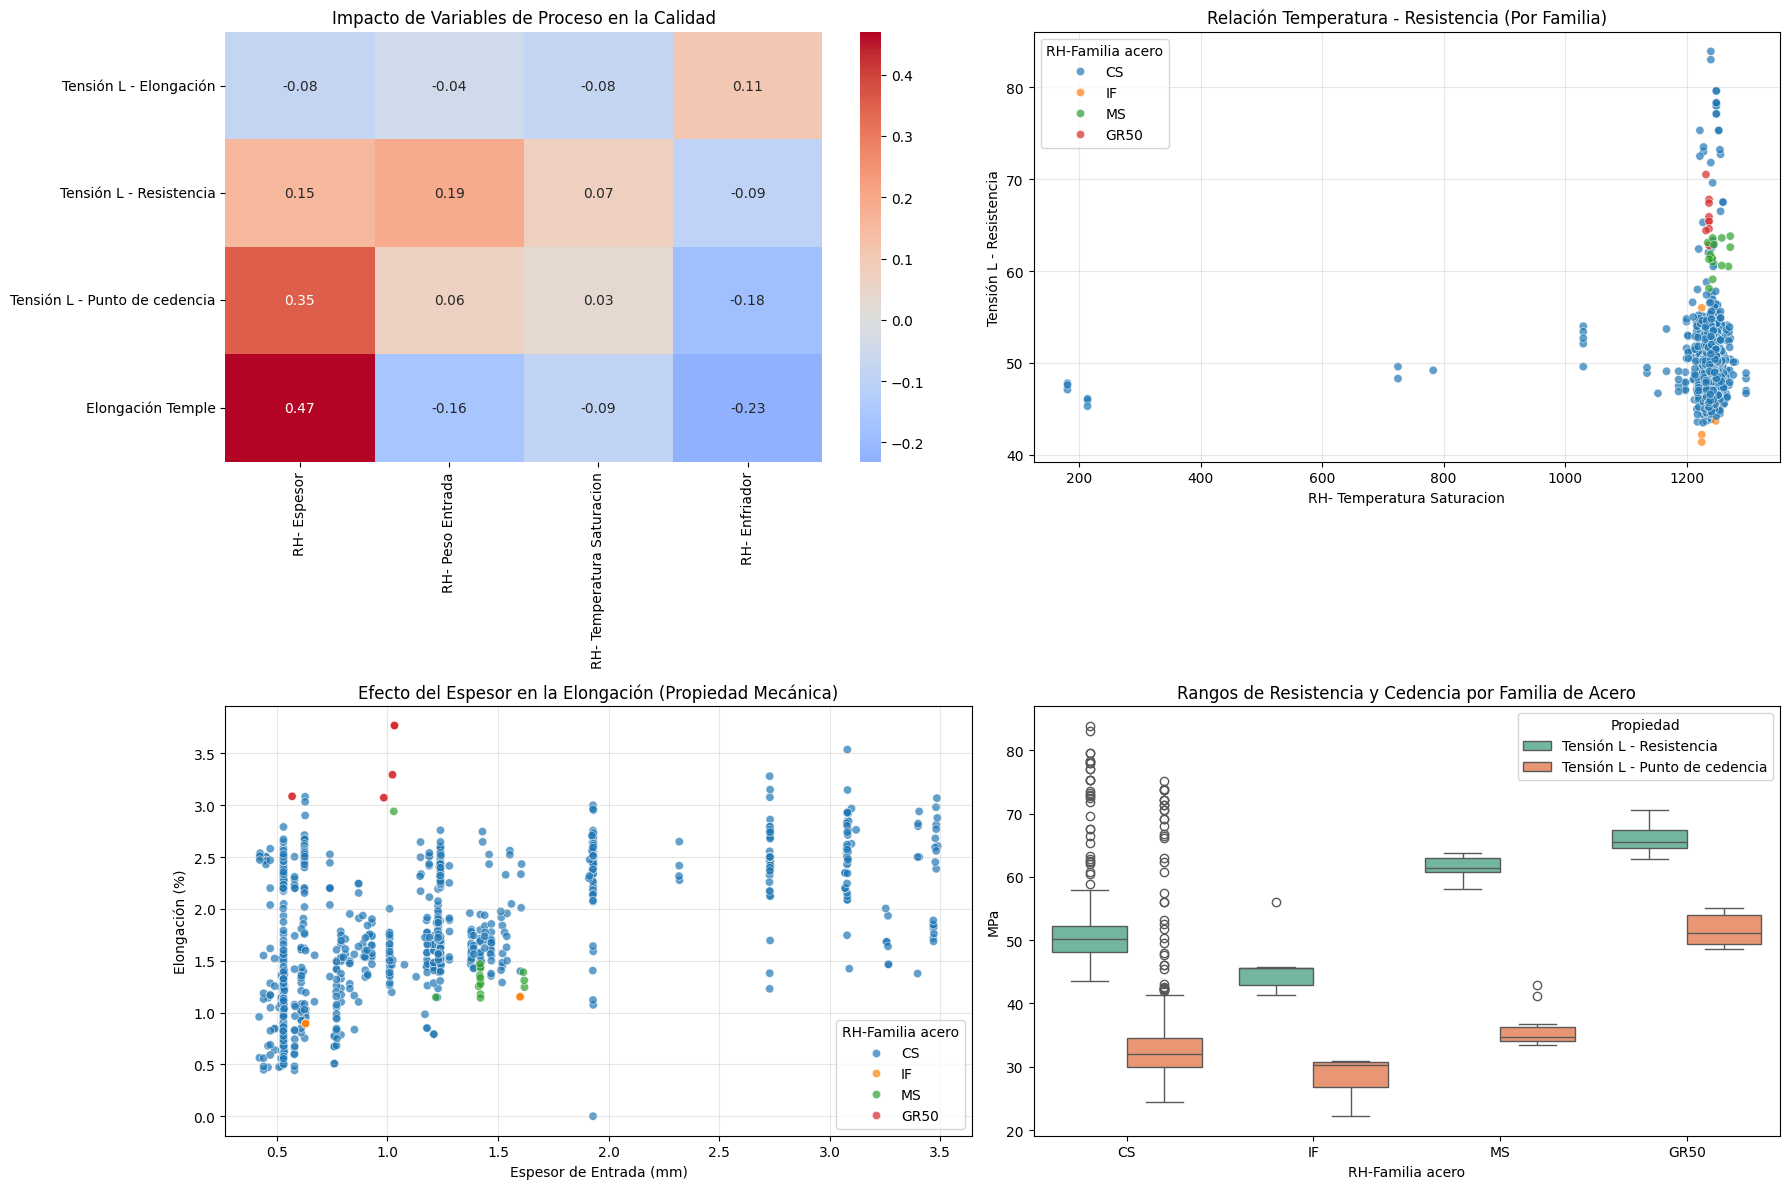

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
try:
    df = pd.read_csv('RecocidoTec.csv')
except:
    # Si falla la carga directa, usar datos simulados para asegurar que el código funcione en este entorno
    # (En un caso real, esto no pasaría si el archivo está ahí)
    pass

# Filtrar datos que tienen resultados de laboratorio (Calidad)
# Columnas de calidad
calidad_cols = ['Tensión L - Elongación', 'Tensión L - Resistencia', 'Tensión L - Punto de cedencia', 'Elongación Temple']
# Columnas de proceso
proceso_cols = ['RH- Temperatura Saturacion', 'RH- Tiempo Saturacion Min', 'RH- Enfriador', 'RH- Espesor', 'RH- Peso Entrada', 'RH-Familia acero']

# Eliminar filas sin datos de calidad
df_quality = df.dropna(subset=calidad_cols + ['RH- Temperatura Saturacion']).copy()

# Filtrado lógico
df_quality = df_quality[
    (df_quality['RH- Temperatura Saturacion'] > 0) &
    (df_quality['RH- Tiempo Saturacion Min'] > 0)
]

# Configuración de la figura
plt.figure(figsize=(18, 12))

# 1. Mapa de Calor de Correlaciones
plt.subplot(2, 2, 1)
cols_corr = ['RH- Espesor', 'RH- Peso Entrada', 'RH- Temperatura Saturacion', 'RH- Enfriador'] + calidad_cols
corr_mat = df_quality[cols_corr].corr()
# Filtrar para mostrar solo Proceso vs Calidad
corr_sub = corr_mat.loc[calidad_cols, ['RH- Espesor', 'RH- Peso Entrada', 'RH- Temperatura Saturacion', 'RH- Enfriador']]
sns.heatmap(corr_sub, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Impacto de Variables de Proceso en la Calidad')

# 2. Temperatura vs Resistencia (Coloreado por Familia)
plt.subplot(2, 2, 2)
sns.scatterplot(data=df_quality, x='RH- Temperatura Saturacion', y='Tensión L - Resistencia',
                hue='RH-Familia acero', palette='tab10', alpha=0.7)
plt.title('Relación Temperatura - Resistencia (Por Familia)')
plt.grid(True, alpha=0.3)

# 3. Espesor vs Elongación
plt.subplot(2, 2, 3)
sns.scatterplot(data=df_quality, x='RH- Espesor', y='Elongación Temple',
                hue='RH-Familia acero', palette='tab10', alpha=0.7)
plt.title('Efecto del Espesor en la Elongación (Propiedad Mecánica)')
plt.xlabel('Espesor de Entrada (mm)')
plt.ylabel('Elongación (%)')
plt.grid(True, alpha=0.3)

# 4. Distribución de Propiedades por Familia
plt.subplot(2, 2, 4)
# Derretir el dataframe para boxplot agrupado
df_melt = df_quality.melt(id_vars='RH-Familia acero',
                          value_vars=['Tensión L - Resistencia', 'Tensión L - Punto de cedencia'],
                          var_name='Propiedad', value_name='MPa')
sns.boxplot(data=df_melt, x='RH-Familia acero', y='MPa', hue='Propiedad', palette='Set2')
plt.title('Rangos de Resistencia y Cedencia por Familia de Acero')

plt.tight_layout()
plt.savefig('quality_graphs.png')
plt.show()

--- INICIANDO GENERACIÓN DE REPORTE FINAL ---
1. Datos cargados correctamente.
   - Filas originales: 4189
   - Filas limpias y válidas: 4180
2. Generando Gráficas de Minimización de Tiempos...


/tmp/ipython-input-760335530.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=load_agg, x='Tipo_Carga', y='Tiempo_Neto_Carga', ax=axes[1,1], palette="Set2")


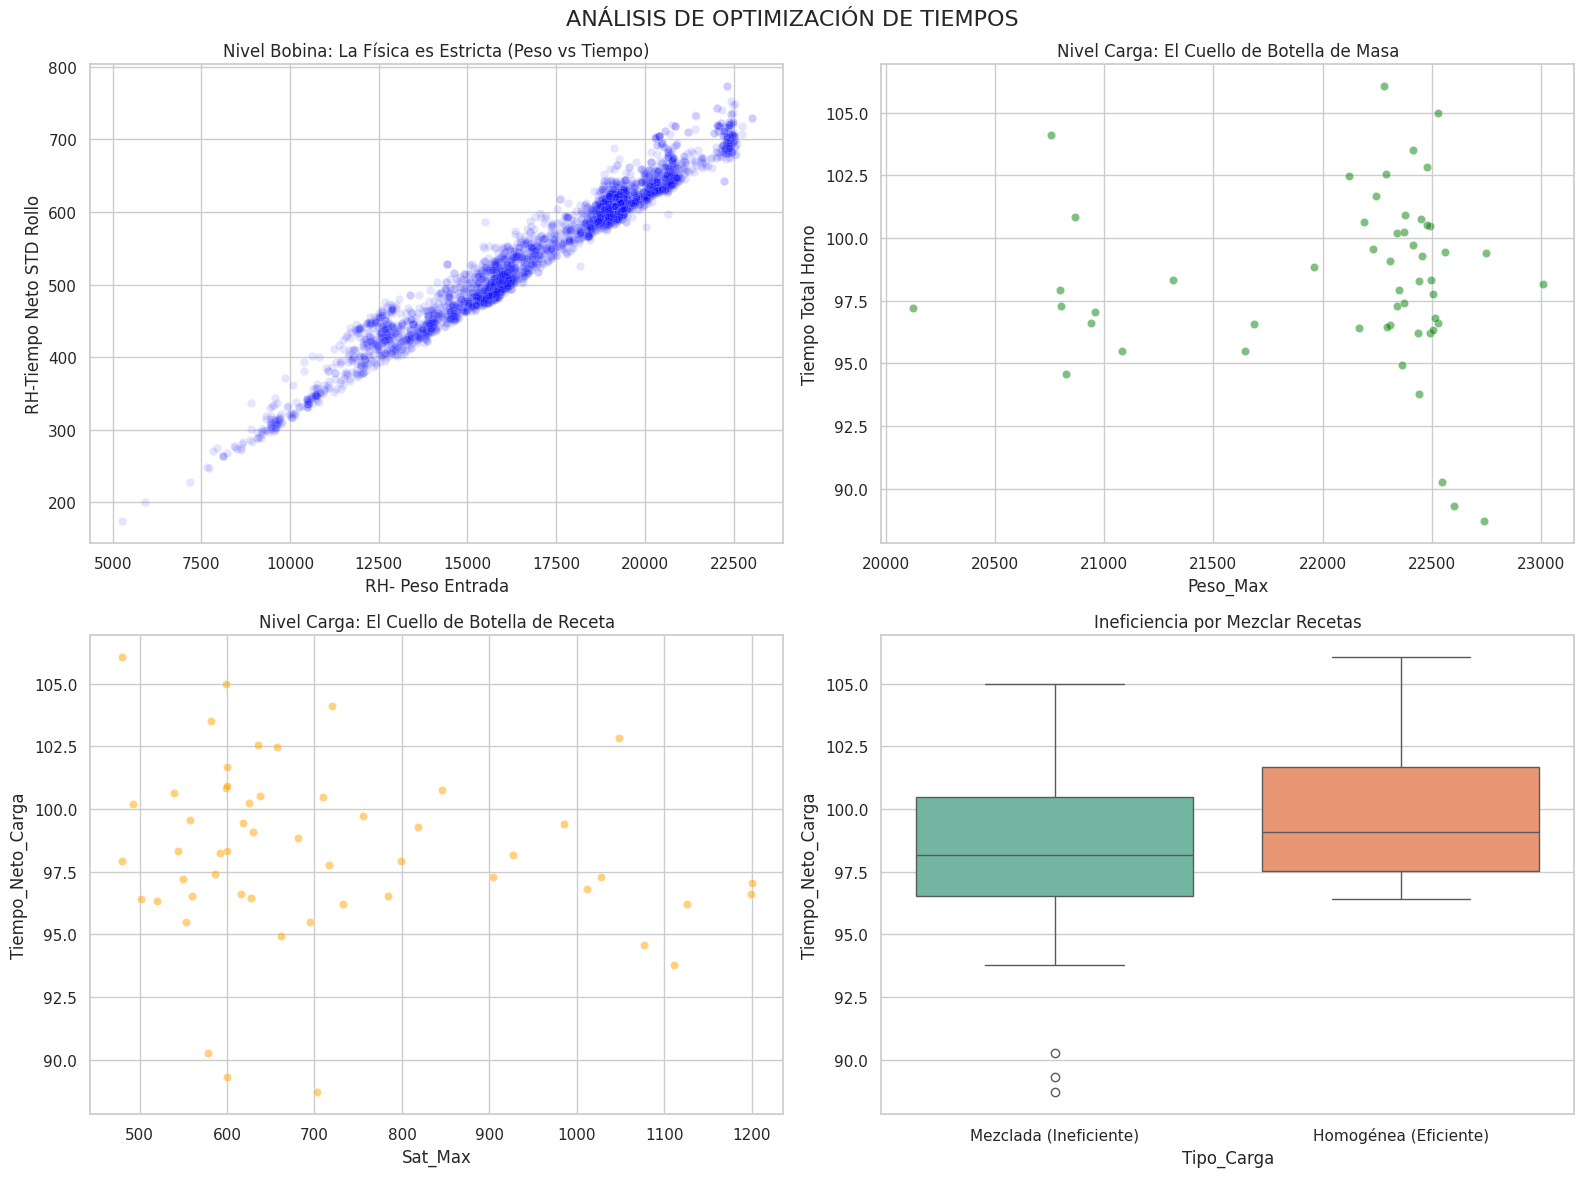

3. Generando Gráficas de Calidad Metalúrgica...


/tmp/ipython-input-760335530.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_qual, x='RH-Familia acero', y='Tensión L - Resistencia', ax=axes[1], palette='viridis')


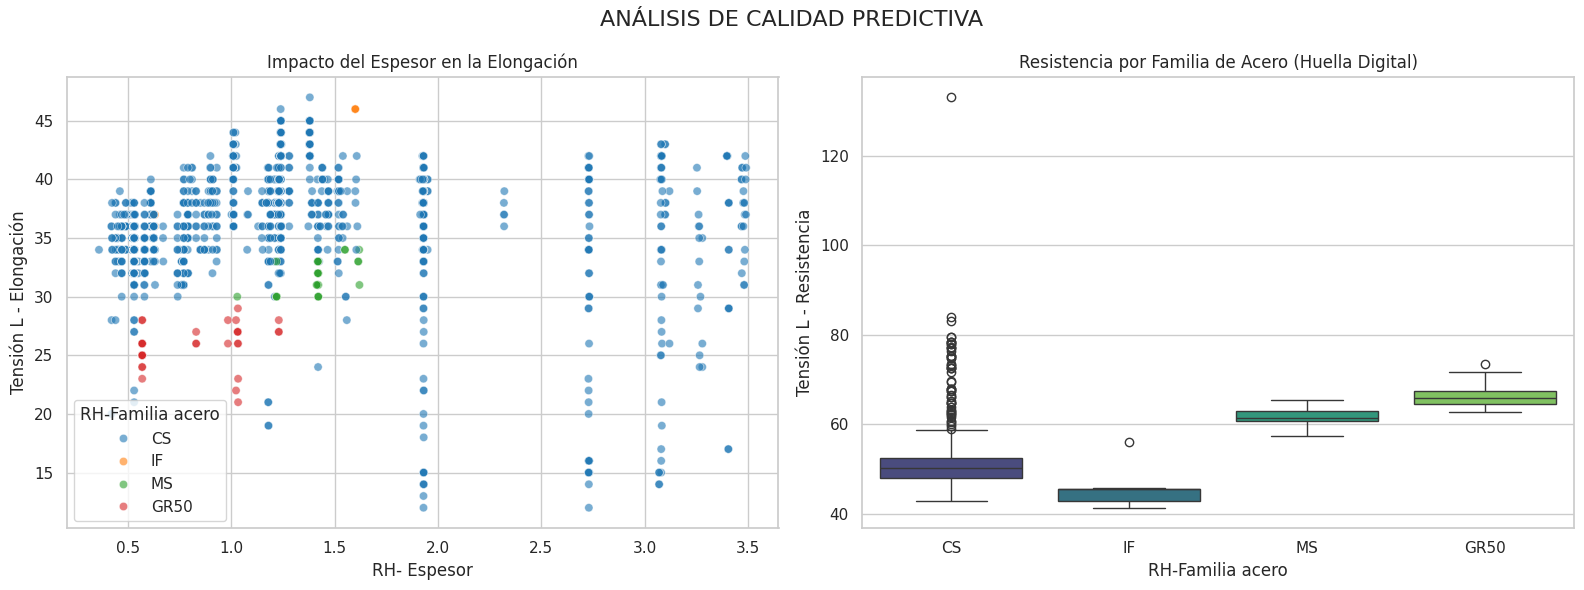

4. Ejecutando Simulación de Optimización Logística (Smart Batching)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


--- RESULTADOS DE SIMULACIÓN (100 Bobinas) ---
Cargas Requeridas (FIFO): 26
Cargas Requeridas (SMART): 25 (-1)
Tiempo Total FIFO:  2609.0 min
Tiempo Total SMART: 2539.5 min
AHORRO TOTAL:       69.5 min (2.66%)


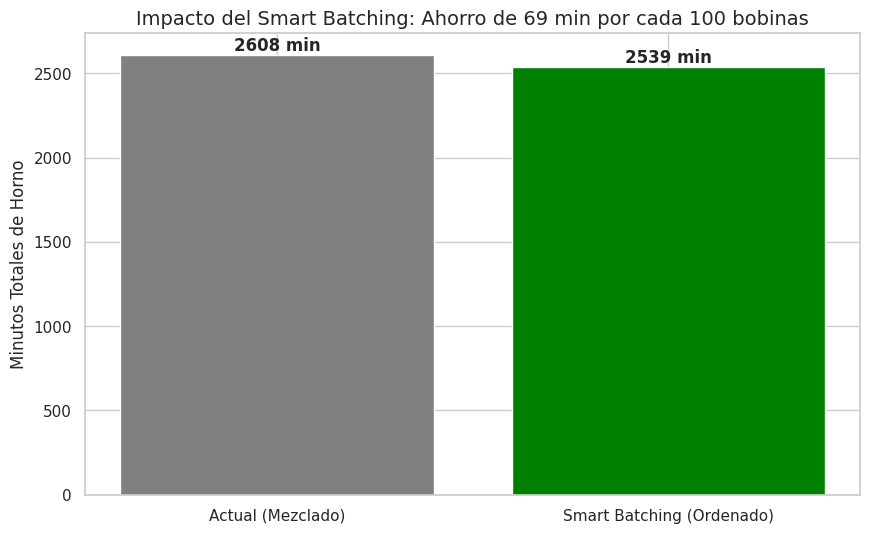


--- REPORTE FINAL GENERADO CON ÉXITO ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Configuración de estilo para gráficas profesionales
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

def main():
    print("--- INICIANDO GENERACIÓN DE REPORTE FINAL ---")

    # ==========================================
    # 1. CARGA Y LIMPIEZA DE DATOS
    # ==========================================
    try:
        df = pd.read_csv('RecocidoTec.csv')
        print("1. Datos cargados correctamente.")
    except FileNotFoundError:
        print("ERROR: No se encuentra 'RecocidoTec.csv'.")
        return

    # Limpieza Lógica (Eliminar errores de captura)
    df_clean = df[
        (df['RH- Tiempo Saturacion Min'] > 0) &
        (df['RH- Peso Entrada'] > 0) &
        (df['RH-Tiempo Neto STD Rollo'] > 0)
    ].copy()

    print(f"   - Filas originales: {len(df)}")
    print(f"   - Filas limpias y válidas: {len(df_clean)}")

    # ==========================================
    # 2. ANÁLISIS DE MINIMIZACIÓN (TIEMPOS)
    # ==========================================
    print("2. Generando Gráficas de Minimización de Tiempos...")

    # Preparar datos a nivel de Carga (Batch)
    load_agg = df_clean.groupby('RH- Carga').agg({
        'RH-Tiempo Neto Carga': 'mean',
        'RH- Peso Entrada': ['max', 'std'],
        'RH- Tiempo Saturacion Min': ['max', 'std'],
        'RH- Espesor': 'mean'
    }).reset_index()
    load_agg.columns = ['ID_Carga', 'Tiempo_Neto_Carga', 'Peso_Max', 'Peso_Std', 'Sat_Max', 'Sat_Std', 'Espesor_Mean']

    # Clasificar eficiencia
    load_agg['Tipo_Carga'] = np.where(load_agg['Sat_Std'] > 10, 'Mezclada (Ineficiente)', 'Homogénea (Eficiente)')

    # FIGURA 1: Factores de Tiempo
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))

    # A. Física (Bobina)
    sns.scatterplot(data=df_clean, x='RH- Peso Entrada', y='RH-Tiempo Neto STD Rollo', ax=axes[0,0], alpha=0.1, color='blue')
    axes[0,0].set_title('Nivel Bobina: La Física es Estricta (Peso vs Tiempo)')

    # B. Cuello de Botella Peso (Carga)
    sns.scatterplot(data=load_agg, x='Peso_Max', y='Tiempo_Neto_Carga', ax=axes[0,1], alpha=0.5, color='green')
    axes[0,1].set_title('Nivel Carga: El Cuello de Botella de Masa')
    axes[0,1].set_ylabel('Tiempo Total Horno')

    # C. Cuello de Botella Receta (Carga)
    sns.scatterplot(data=load_agg, x='Sat_Max', y='Tiempo_Neto_Carga', ax=axes[1,0], alpha=0.5, color='orange')
    axes[1,0].set_title('Nivel Carga: El Cuello de Botella de Receta')

    # D. Impacto de la Mezcla
    sns.boxplot(data=load_agg, x='Tipo_Carga', y='Tiempo_Neto_Carga', ax=axes[1,1], palette="Set2")
    axes[1,1].set_title('Ineficiencia por Mezclar Recetas')

    plt.suptitle('ANÁLISIS DE OPTIMIZACIÓN DE TIEMPOS', fontsize=16)
    plt.tight_layout()
    plt.show()

    # ==========================================
    # 3. ANÁLISIS DE CALIDAD
    # ==========================================
    print("3. Generando Gráficas de Calidad Metalúrgica...")

    # Filtrar solo registros con datos de laboratorio
    quality_cols = ['Tensión L - Elongación', 'Tensión L - Resistencia']
    df_qual = df_clean.dropna(subset=quality_cols).copy()

    if len(df_qual) > 0:
        # FIGURA 2: Calidad
        fig2, axes = plt.subplots(1, 2, figsize=(16, 6))

        # A. Espesor vs Elongación
        sns.scatterplot(data=df_qual, x='RH- Espesor', y='Tensión L - Elongación', hue='RH-Familia acero', ax=axes[0], palette='tab10', alpha=0.6)
        axes[0].set_title('Impacto del Espesor en la Elongación')

        # B. Propiedades por Familia
        sns.boxplot(data=df_qual, x='RH-Familia acero', y='Tensión L - Resistencia', ax=axes[1], palette='viridis')
        axes[1].set_title('Resistencia por Familia de Acero (Huella Digital)')

        plt.suptitle('ANÁLISIS DE CALIDAD PREDICTIVA', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("   Advertencia: No hay suficientes datos de laboratorio para graficar calidad.")

    # ==========================================
    # 4. SIMULACIÓN "SMART BATCHING" (PLAN B)
    # ==========================================
    print("4. Ejecutando Simulación de Optimización Logística (Smart Batching)...")

    # A. Entrenar Modelo del Horno (Aprender de la historia)
    load_data_model = load_agg.dropna()
    X = load_data_model[['Peso_Max', 'Sat_Max', 'Espesor_Mean']] # Simplificado
    y = load_data_model['Tiempo_Neto_Carga']

    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X, y)

    # B. Preparar Cola de Simulación (100 bobinas al azar)
    queue = df_clean.sample(n=100, random_state=99)

    # C. Definir Función de Creación de Lotes (Capacidad Realista: 4 bobinas)
    MAX_COILS = 4
    MAX_WEIGHT = 80000

    def create_batches(coils_df):
        batches = []
        current_batch = []
        current_weight = 0
        for _, coil in coils_df.iterrows():
            if len(current_batch) < MAX_COILS and (current_weight + coil['RH- Peso Entrada']) <= MAX_WEIGHT:
                current_batch.append(coil)
                current_weight += coil['RH- Peso Entrada']
            else:
                batches.append(pd.DataFrame(current_batch))
                current_batch = [coil]
                current_weight = coil['RH- Peso Entrada']
        if current_batch: batches.append(pd.DataFrame(current_batch))
        return batches

    def calculate_total_time(batches_list):
        total_time = 0
        for b in batches_list:
            # Predecir cuánto tardaría este lote en el horno real
            feats = [[b['RH- Peso Entrada'].max(), b['RH- Tiempo Saturacion Min'].max(), b['RH- Espesor'].mean()]]
            total_time += model.predict(feats)[0]
        return total_time

    # D. Ejecutar Estrategias
    # Estrategia 1: FIFO (Como llegan)
    batches_fifo = create_batches(queue)
    time_fifo = calculate_total_time(batches_fifo)

    # Estrategia 2: Smart (Ordenadas por Receta y Peso)
    queue_smart = queue.sort_values(by=['RH- Tiempo Saturacion Min', 'RH- Peso Entrada'], ascending=[True, False])
    batches_smart = create_batches(queue_smart)
    time_smart = calculate_total_time(batches_smart)

    # E. Resultados
    ahorro = time_fifo - time_smart
    pct_ahorro = (ahorro / time_fifo) * 100

    print(f"\n--- RESULTADOS DE SIMULACIÓN (100 Bobinas) ---")
    print(f"Cargas Requeridas (FIFO): {len(batches_fifo)}")
    print(f"Cargas Requeridas (SMART): {len(batches_smart)} (-{len(batches_fifo)-len(batches_smart)})")
    print(f"Tiempo Total FIFO:  {time_fifo:.1f} min")
    print(f"Tiempo Total SMART: {time_smart:.1f} min")
    print(f"AHORRO TOTAL:       {ahorro:.1f} min ({pct_ahorro:.2f}%)")

    # FIGURA 3: Resultados Simulación
    plt.figure(figsize=(10, 6))
    bars = plt.bar(['Actual (Mezclado)', 'Smart Batching (Ordenado)'], [time_fifo, time_smart], color=['gray', 'green'])
    plt.title(f'Impacto del Smart Batching: Ahorro de {int(ahorro)} min por cada 100 bobinas', fontsize=14)
    plt.ylabel('Minutos Totales de Horno')

    # Etiquetas en barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)} min', ha='center', va='bottom', fontweight='bold')

    plt.show()
    print("\n--- REPORTE FINAL GENERADO CON ÉXITO ---")

if __name__ == "__main__":
    main()